# Cross lingual transfer experiments on SQuAD 1.1 - like datasets

In [ ]:
! nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Setup

In [ ]:
! pip install datasets --quiet
! pip install neptune-client --quiet
! pip install transformers --quiet
! pip install pytorch-lightning --quiet

     |████████████████████████████████| 266kB 3.9MB/s 
     |████████████████████████████████| 122kB 5.2MB/s 
     |████████████████████████████████| 245kB 5.5MB/s 
     |████████████████████████████████| 245kB 3.8MB/s 
     |████████████████████████████████| 829kB 23.0MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 174kB 58.1MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 133kB 45.4MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
     |████████████████████████████████| 2.5MB 4.0MB/s 
     |████████████████████████████████| 901kB 39.8MB/s 
     |████████████████████████████████| 3.3MB 48.3MB/s 
     |████████████████████████████████| 819kB 4.0MB/s 
     |████████████████████████████████| 235kB 6.0MB/s 
     |████████████████████████████████| 645kB 8.7MB/s 
     |████████████████████████████████| 10.6MB 303kB/s 
     |████████████████████████████████| 1.3MB 35.1MB/s 
     |

## Imports

In [ ]:
import collections
import csv
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pytorch_lightning as pl
import random
import re
import shutil
import string
import time
import transformers

import torch
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from transformers import (AutoConfig,
                          AutoTokenizer,
                          AutoModelForQuestionAnswering,
                          BatchEncoding,
                          get_scheduler,
                          PreTrainedTokenizerFast,
                          SchedulerType)

from transformers.data.data_collator import DataCollatorWithPadding

from datasets import load_metric

from collections import Counter, defaultdict
from dataclasses import astuple, dataclass
from getpass import getpass
from google.colab import drive
from pprint import pprint
from tqdm.auto import tqdm
from typing import List, Tuple, Union


print('Transformers:', transformers.__version__)
print('PyTorch Lightning:', pl.__version__)

Transformers: 4.8.2
PyTorch Lightning: 1.3.8


In [ ]:
BERT_ENGLISH = "bert-base-cased"
BERTIMBAU = "neuralmind/bert-base-portuguese-cased"
# BERTIMBAU_FROM_SCRATCH = "./drive/My Drive/PF13/bertimbau/bertimbau_from_scratch"
BERT_GERMAN = "bert-base-german-cased"
MBERT = "bert-base-multilingual-cased"
# MBERT_BRWAC = "./drive/My Drive/PF13/mbert/mbert_on_brwac"
RUBERT = "DeepPavlov/rubert-base-cased"
BERT_CHINESE = "bert-base-chinese"
PHOBERT = "vinai/phobert-base"

ASSIN2 = "assin2"
MNLI = "mnli"



SQUAD = "squad"
FAQUAD = "faquad"
SBERSQUAD = "sbersquad"
TQUAD = "tquad"
GERMANQUAD = "germanquad"
VIQUAD = "viquad"

## Parameters

In [ ]:
model_name = BERTIMBAU # @param["BERT_ENGLISH", "BERTIMBAU", "BERTIMBAU_FROM_SCRATCH", "MBERT", "MBERT_BRWAC", "RUBERT", "BERT_CHINESE", "BERT_GERMAN", "PHOBERT"] {type: "raw"}
use_pretraining = True # @param{type: "boolean"}

# Dataset
train_dataset_name = VIQUAD # @param["SQUAD", "FAQUAD", "SBERSQUAD", "TQUAD", "GERMANQUAD", "VIQUAD"] {type:"raw"}
xlang_dataset_name = FAQUAD # @param["SQUAD", "FAQUAD", "SBERSQUAD", "TQUAD", "GERMANQUAD", "VIQUAD", "None"] {type:"raw"}

batch_size =  16# @param {type: "integer"}
max_length = 384 # @param {type: "integer"}
doc_stride = 128 # @param {type: "integer"}
max_answer_length = 30 # @param {type: "integer"}
n_best_size = 20  # @param {type: "integer"}
train_dataset_slice =   128# @param

# Training
accumulate_grad_batches =  1# @param {type: "integer"}
max_epochs =  3# @param {type: "integer"}
val_check_interval = 1.0 # @param {type: "raw"}
log_every_n_steps =  50# @param {type: "integer"}
precision =  16# @param {type: "integer"}
patience =  3# @param {type: "integer"}

# Optimization
learning_rate = 3e-5 # @param {type: "number"}
weight_decay = 0.0 # @param {type: "number"}
betas = (0.9, 0.999) # @param {type: "raw"}
eps = 1e-8 # @param {type: "number"}
# Output
output_dir = r"/drive/MyDrive/projeto_final/output" # @param


seed = 42 # @param[42, 123, 1337] {type: "raw"}

In [ ]:
drive.mount('/drive', force_remount=True)


Mounted at /drive


In [ ]:
pl.seed_everything(seed)

Global seed set to 42


42

In [ ]:
def get_experiment_path():
  if model_name == "neuralmind/bert-base-portuguese-cased":
    model = 'bertimbau'
  else:
    model = model_name
  folder_name = f'{model}_{train_dataset_name}_{xlang_dataset_name}_slice{train_dataset_slice}_{time.strftime("%Y-%h-%d.%H-%M-%S")}'
  experiment_path = os.path.join(output_dir, folder_name)
  os.makedirs(output_dir, exist_ok=True)
  os.makedirs(experiment_path)
  print(experiment_path)
  return experiment_path

## Volumes and Keys

In [ ]:
neptune_key_location = os.path.join(output_dir, 'neptune_key')
print(neptune_key_location)
if os.path.exists(neptune_key_location):
    with open(neptune_key_location, 'r') as nep_key:
        all_lines = nep_key.readlines()

        NEPTUNE_API_KEY = all_lines[0].strip()
        NEPTUNE_PROJECT = all_lines[1].strip()
else:
    NEPTUNE_API_KEY = getpass('NEPTUNE KEY:')
    NEPTUNE_PROJECT = input('NEPTUNE PROJECT:')

    with open(neptune_key_location, 'w+') as nep_key:
        nep_key.writelines([NEPTUNE_API_KEY + '\n', NEPTUNE_PROJECT + '\n'])
# NEPTUNE_API_KEY, NEPTUNE_PROJECT

/drive/MyDrive/projeto_final/output/neptune_key


## Download the Dataset

In [ ]:
def download_dataset(train_dataset_name, xlang_dataset_name):
  if 'faquad' in [train_dataset_name, xlang_dataset_name]:
      ! mkdir -p ./faquad

      ! curl https://raw.githubusercontent.com/liafacom/faquad/master/data/train.json --output ./faquad/train.json
      ! curl https://raw.githubusercontent.com/liafacom/faquad/master/data/dev.json --output ./faquad/dev.json

  if 'squad' in [train_dataset_name, xlang_dataset_name]:
      ! mkdir -p ./squad

      ! curl https://raw.githubusercontent.com/rajpurkar/SQuAD-explorer/master/dataset/train-v1.1.json --output ./squad/train.json
      ! curl https://raw.githubusercontent.com/rajpurkar/SQuAD-explorer/master/dataset/dev-v1.1.json --output ./squad/dev.json

  if 'sbersquad' in [train_dataset_name, xlang_dataset_name]:
      ! mkdir -p ./sbersquad

      ! curl https://files.deeppavlov.ai/datasets/sber_squad_clean-v1.1.tar.gz --output ./sbersquad/sber_squad_clean-v1.1.tar.gz
      ! tar -xvf ./sbersquad/sber_squad_clean-v1.1.tar.gz -C ./sbersquad/

      ! mv ./sbersquad/train-v1.1.json ./sbersquad/train.json
      ! mv ./sbersquad/dev-v1.1.json ./sbersquad/dev.json
      ! rm ./sbersquad/sber_squad_clean-v1.1.tar.gz

  if 'tquad' in [train_dataset_name, xlang_dataset_name]:
      ! mkdir -p ./tquad

      ! curl https://raw.githubusercontent.com/TQuad/turkish-nlp-qa-dataset/master/train-v0.1.json --output ./tquad/train.json
      ! curl https://raw.githubusercontent.com/TQuad/turkish-nlp-qa-dataset/master/dev-v0.1.json --output ./tquad/dev.json

  if 'germanquad' in [train_dataset_name, xlang_dataset_name]:
      ! mkdir -p ./germanquad

      ! curl https://germanquad.s3.amazonaws.com/GermanQuAD.zip --output ./germanquad/germanquad.zip
      ! unzip ./germanquad/germanquad.zip -d ./germanquad

      ! mv -f ./germanquad/GermanQuAD/GermanQuAD_train.json ./germanquad/train.json
      ! mv -f ./germanquad/GermanQuAD/GermanQuAD_test.json ./germanquad/dev.json

      ! rm ./germanquad/germanquad.zip

  if VIQUAD in [train_dataset_name, xlang_dataset_name]:
      ! mkdir -p ./viquad

      ! cp "/drive/MyDrive/projeto_final/train_ViQuAD.json" ./viquad/train.json
      ! cp "/drive/MyDrive/projeto_final/dev_ViQuAD.json" ./viquad/dev.json



## Prepare the dataset

In [ ]:
@dataclass
class InputExample():
    id: str
    question: str
    context: str
    answers: List[str]
    answers_start: List[int]

In [ ]:
def load_dataset(dataset_path):
    examples = []

    with open(dataset_path, "r", encoding="utf-8") as fp:
        data = json.load(fp)

    for article in data["data"]:
        for paragraph in article["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                question = str(qa["question"])
                question_id = str(qa["id"])
                ans_text = []
                ans_start = []
                for answer in qa["answers"]:
                    ans_text.append(str(answer["text"]))
                    ans_start.append(int(answer["answer_start"]))

                examples.append(
                    InputExample(question_id, question, context, ans_text, ans_start)
                )

    return examples

The dataset is tokenized in order to be fed into our model. For that, we use the Huggingface's tokenizers library. We just create a utility function to create a tokenizer from its name or to use an already provided instance of it.

In [ ]:
def get_tokenizer(tokenizer: Union[str, PreTrainedTokenizerFast]):
    return (tokenizer if isinstance(tokenizer, PreTrainedTokenizerFast) 
                      else AutoTokenizer.from_pretrained(
                          tokenizer,
                          do_lower_case=False,
                          use_fast=True))

## Breaks words

We'll perform some experiments for analyzing the performance of our model based on how the tokenizer breaks words. So, we create this function `sub_token_count` that does thar for us:

In [ ]:
test_sub_words= False # @param {type: 'boolean'}


In [ ]:
def count_subwords(word_ids: List[int]):
    freq = Counter(word_ids).most_common()
    subtoken_count = 0
    freq_idx = 0

    while freq_idx < len(freq) and freq[freq_idx][1] > 1:
        subtoken_count += freq[freq_idx][1] - 1  # We ignore the root subtoken
        freq_idx += 1

    return subtoken_count


def sub_token_count(encoding: BatchEncoding, feature_idx: int):
    seq_ids = encoding.sequence_ids(feature_idx)

    ctx_wrd = [
        w for i, w in enumerate(encoding.word_ids(feature_idx)) if seq_ids[i] == 1
    ]
    qas_wrd = [
        w for i, w in enumerate(encoding.word_ids(feature_idx)) if seq_ids[i] == 0
    ]

    return (
        len(qas_wrd) + len(ctx_wrd),
        (len(qas_wrd), count_subwords(qas_wrd)),
        (len(ctx_wrd), count_subwords(ctx_wrd)),
    )


In [ ]:
if test_sub_words:
    tokenizer = get_tokenizer(model_name)

    encoding_demo = tokenizer('is this a question?',
                            'this should be the context.')

    total, for_question, for_context = sub_token_count(encoding_demo, 0)

    print('Context (tokens, subtokens):', for_context)
    print('Question (token, subtokens):', for_question)

    print('Word Ids:', encoding_demo.word_ids(0))

    encoding_demo = tokenizer('is this a more elaborate question to be splitted?',
                          'this should be the context with some additional subwords for a tokenizer.')

    total, for_question, for_context = sub_token_count(encoding_demo, 0)

    print('Context (tokens, subtokens):', for_context)
    print('Question (token, subtokens):', for_question)

    print('Word Ids:', encoding_demo.word_ids(0))

## Prepare data

In [ ]:
def prepare_train_features(
    tokenizer, examples: List[InputExample], max_length: int, doc_stride: int  ##02 Vantagens de definir type?
):
    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        [e.question for e in examples],
        [e.context for e in examples],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples[sample_index].answers
        answers_start = examples[sample_index].answers_start
        # If no answers are given, set the cls_index as answer.
        if len(answers_start) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers_start[0]
            end_char = start_char + len(answers[0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (
                offsets[token_start_index][0] <= start_char
                and offsets[token_end_index][1] >= end_char
            ):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while (
                    token_start_index < len(offsets)
                    and offsets[token_start_index][0] <= start_char
                ):  
                    print('')
                    token_start_index += 1

                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:

def prepare_validation_features(
    tokenizer, examples: List[InputExample], max_length: int, doc_stride: int
):
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        [e.question for e in examples],
        [e.context for e in examples],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []
    tokenized_examples["token_counts"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples[sample_index].id)

        # We add token counts for latter analysis
        tokenized_examples["token_counts"].append(
            sub_token_count(tokenized_examples, i))

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

We encapsulate all this in a torch `Dataset` class:

In [ ]:
class SquadDataset(Dataset):
    input_features = ['input_ids', 'token_type_ids', 'attention_mask', 
                      'start_positions', 'end_positions']

    def __init__(self,
                 dataset_name: str,
                 split: str,
                 tokenizer: Union[str, PreTrainedTokenizerFast],
                 max_length: int = 384,
                 doc_stride: int = 128,
                 dataset_slice: Union[int, float] = None):
        
        self.tokenizer = get_tokenizer(tokenizer)
        self.dataset_path = os.path.join('./', dataset_name, f'{split}.json')
        self.max_length = max_length 
        self.doc_stride = doc_stride
        

        self.examples = load_dataset(self.dataset_path)

        if dataset_slice:
            n = len(self.examples)
            num_examples = (int(n * dataset_slice) if isinstance(dataset_slice, float)
                            else dataset_slice)
            
            random.shuffle(self.examples)

            self.examples = self.examples[:num_examples]

        if split == "train":
            self.features = prepare_train_features(
                self.tokenizer, self.examples, self.max_length, self.doc_stride)
        else:
            self.features = prepare_validation_features(
                self.tokenizer, self.examples, self.max_length, self.doc_stride)

    def __len__(self):
        return len(self.features.encodings)

    def __getitem__(self, idx):
        input_feature = {}

        for key in self.input_features:
            if key in self.features:
                input_feature[key] = torch.tensor(self.features[key][idx])

        return input_feature

## Data Exploration

In [ ]:
data_exploration = False # @param {type: 'boolean'}


In [ ]:
if data_exploration:
    train_demo_dataset = SquadDataset(train_dataset_name, "train", model_name, max_length, doc_stride, None)
    print('Train Examples Size:', len(train_demo_dataset.examples))
    print('Train Features Size:', len(train_demo_dataset))
    print('Train Features:', train_demo_dataset.features.keys())

In [ ]:
if data_exploration:
    dev_dataset = SquadDataset(train_dataset_name, "dev", model_name, max_length, doc_stride)
    print('Dev Examples Size:', len(dev_dataset.examples))
    print('Dev Features Size:', len(dev_dataset))
    print('Dev Features:', dev_dataset.features.keys())

In [ ]:
if data_exploration:
    pprint(dev_dataset.examples[0])

In [ ]:
if data_exploration:
    for example in dev_dataset.examples[:10]:
        
        print(example.id, ':', example.question)

In [ ]:
if data_exploration:
    for example in dev_dataset.examples[:10]:
        print(example.id, ':', example.answers)
        print(example.id, ':', example.answers_start)
        print('=' * 50)

In [ ]:
if data_exploration:
    print(dev_dataset[0])

In [ ]:
if data_exploration:
    print(dev_dataset.tokenizer.decode(dev_dataset[0]['input_ids']))

## Post Processing Model Predictions

In [ ]:
def postprocess_qa_predictions(
    examples, features, raw_predictions, tokenizer, n_best_size=20, max_answer_length=30
):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {e.id: i for i, e in enumerate(examples)}
    features_per_example = collections.defaultdict(list)

    for i, example_id in enumerate(features["example_id"]):
        features_per_example[example_id_to_index[example_id]].append(i)

    # The dictionaries we have to fill.
    # WARNING: Changing to list to be able to handle datasets with repeated ids
    predictions = []

    # Logging.
    print(
        f"Post-processing {len(examples)} example predictions split into {len(features.encodings)} features."
    )

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None  # Only used if squad_v2 is True.
        valid_answers = []

        context = example.context
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            if feature_index >= all_start_logits.shape[0]:
                continue  # Maybe a validation on a subset

            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features["offset_mapping"][feature_index]

            # Update minimum null prediction.
            cls_index = features["input_ids"][feature_index].index(
                tokenizer.cls_token_id
            )
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[
                -1 : -n_best_size - 1 : -1
            ].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]

                    ans_wrd = [
                        w
                        for i, w in enumerate(features.word_ids(feature_index))
                        if start_index <= i <= end_index
                    ]

                    ans_tokens = count_subwords(ans_wrd)

                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char:end_char],
                            "token_counts": features["token_counts"][feature_index],
                            "ans_counts": (len(ans_wrd), ans_tokens),
                            "references": example.answers,
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[
                0
            ]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {
                "text": "",
                "score": 0.0,
                "token_counts": None,
                "ans_counts": None,
                "references": example.answers,
            }

        # Let's pick our final answer: the best one
        predictions.append({"id": example.id, "answer": best_answer})

    return predictions

## Logging

We also provide a function for logging predictions:

In [ ]:
def log_artifact(instances,
                 logger,
                 epoch,
                 step,
                 filename,
                 output_dir):

    file = f'{filename}-epoch={epoch}-step={step}'

    with open(os.path.join(output_dir, file), 'w+') as log_file:
        fieldnames = ["id", "score", "text", "token_counts", "ans_counts", "references"]
        writer = csv.DictWriter(log_file, fieldnames=fieldnames)

        writer.writeheader()

        for i in instances:
            writer.writerow({"id": i["id"], **i["answer"]})

    if logger and logger.experiment and hasattr(logger.experiment, 'log_artifact'):
        logger.experiment.log_artifact(log_file.name)

## The Metrics

We use The F1 and Exact Match metric from Hugging Face `datasets` library, which are based on the original SQuAD evaluation script.

In [ ]:
def compute_metrics(metric, examples, final_predictions):
    formatted_predictions = [{"id": pred["id"], "prediction_text": pred["answer"]["text"]} for pred in final_predictions]
    references = [{"id": ex.id, "answers": {"text": ex.answers, "answer_start": ex.answers_start}} for ex in examples]

    return metric.compute(predictions=formatted_predictions, references=references)

## The Model

In [ ]:
def get_parameter_names(model, forbidden_layer_types):
    """
    Returns the names of the model parameters that are not inside a forbidden layer.
    """
    result = []
    for name, child in model.named_children():
        result += [
            f"{name}.{n}"
            for n in get_parameter_names(child, forbidden_layer_types)
            if not isinstance(child, tuple(forbidden_layer_types))
        ]
    # Add model specific parameters (defined with nn.Parameter) since they are not in any child.
    result += list(model._parameters.keys())
    return result

In [ ]:
class SquadModel(pl.LightningModule):
    default_input_features = [
        "input_ids",
        "start_positions",
        "end_positions",
        "attention_mask",
        "token_type_ids",
    ]

    def __init__(
        self,
        pretrained_model: str,
        use_pretraining: bool,
        learning_rate: float,
        train_dataset: str,
        batch_size: int = 16,
        max_length: int = 384,
        doc_stride: int = 128,
        max_answer_length: int = 20,
        n_best_size: int = 20,
        train_dataset_slice: Union[int, float] = None,
        xlang_dataset_name: str = None,
        weight_decay: float = 0.0,
        betas: Tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-8,
        output_dir: str = "./",

    
    ):
        super().__init__()

        self.save_hyperparameters()

        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

        if use_pretraining:
            self.model = AutoModelForQuestionAnswering.from_pretrained(pretrained_model)
        else:
            config = AutoConfig.from_pretrained(pretrained_model)
            self.model = AutoModelForQuestionAnswering.from_config(config)

        self.metrics = [ load_metric("squad", experiment_id="finetune"),
                         load_metric("squad", experiment_id="cross-lingual") ]


    def forward(
        self,
        input_ids,
        attention_mask,
        token_type_ids=None,
        start_positions=None,
        end_positions=None,
        **kwargs,
    ):

        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            start_positions=start_positions,
            end_positions=end_positions,
            return_dict=True,
        )

    def get_num_train_steps(self):
        batches = len(self.train_dataloader())
        effective_accum = self.trainer.accumulate_grad_batches

        return (batches // effective_accum) * self.trainer.max_epochs

    def get_optimizer_parameters(self):
        decay_parameters = get_parameter_names(self.model, [torch.nn.LayerNorm])
        decay_parameters = [name for name in decay_parameters if "bias" not in name]
        
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if n in decay_parameters],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in self.model.named_parameters() if n not in decay_parameters],
                "weight_decay": 0.0,
            },
        ]

        return optimizer_grouped_parameters

    def configure_optimizers(self):
        total_optimization_steps = self.get_num_train_steps()
        optimization_parameters = self.get_optimizer_parameters()

        print("Total Optimization Steps:", total_optimization_steps)

        optimizer = torch.optim.AdamW(
            optimization_parameters,
            lr=self.hparams.learning_rate,
            betas=self.hparams.betas,
            eps=self.hparams.eps,
        )

        scheduler = get_scheduler(
            SchedulerType.LINEAR,
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_optimization_steps,
        )

        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

    """
    ===========================================
                    TRAINING
    ===========================================
    """


    def training_step(self, batch, batch_idx):
        output = self(**batch)

        self.log("train_loss", output.loss)

        return output.loss


    """
    ===========================================
                    VALIDATION
    ===========================================
    """

    def validation_step(self, batch, batch_idx, dataloader_idx=None):
        output = self(**batch)

        return {
            "loader": dataloader_idx,
            "start_logits": output.start_logits.cpu().numpy(),
            "end_logits": output.end_logits.cpu().numpy(),
        }

    def validation_epoch_end(self, outputs):
        if self.hparams.xlang_dataset_name:
            # In the case that a cross language validation dataset
            # is specified, we calculate the results for both datasets
            self._run_validation(outputs[0], self.valid_dataset)
            self._run_validation(outputs[1], self.cross_valid_dataset, "cross_")
        else:
            self._run_validation(outputs, self.valid_dataset)

    def _run_validation(self, outputs, dataset: SquadDataset, prefix=""):
        # print(outputs[0]['start_logits'])
        all_start_logits = np.concatenate([o["start_logits"] for o in outputs])
        all_end_logits = np.concatenate([o["end_logits"] for o in outputs])
        dataloader_idx = outputs[0].get("loader", 0)
        print('passou')
        raw_predictions = (all_start_logits, all_end_logits)
        metric = self.metrics[dataloader_idx]
       
        predictions = postprocess_qa_predictions(
            dataset.examples,
            dataset.features,
            raw_predictions,
            self.tokenizer,
            self.hparams.n_best_size,
            self.hparams.max_answer_length,
        )

        metrics = compute_metrics(metric, dataset.examples, predictions)

        self.log(f"{prefix}val_em", torch.tensor(metrics["exact_match"]))
        self.log(f"{prefix}val_f1", torch.tensor(metrics["f1"]), prog_bar=True)

        log_artifact(
            predictions,
            self.logger,
            self.current_epoch,
            self.global_step,
            f"{prefix}predictions",
            self.hparams.output_dir,
        )
    

    """
    ===========================================
                        TEST
    ===========================================
    """

    def test_step(self, batch, batch_idx, dataloader_idx=None):
      return self.validation_step(batch, batch_idx, dataloader_idx=0)
    
    # def test_epoch_end(self, outputs):
    #   return self.validation_epoch_end(outputs)

    def test_epoch_end(self, outputs):
        if self.hparams.xlang_dataset_name:
            # In the case that a cross language validation dataset
            # is specified, we calculate the results for both datasets
            print(self.hparams.xlang_dataset_name, 'entrou')
            self._run_validation(outputs, self.cross_valid_dataset)
        else:
            self._run_validation(outputs, self.valid_dataset)
    
    def test_dataloader(self):

      if not self.hparams.xlang_dataset_name:
        test_loader1 = self._create_dataloader(self.valid_dataset)
        return test_loader1
      else:

        test_loader2 = self._create_dataloader(self.cross_valid_dataset)
        return test_loader2

    """
    ===========================================
                    DATA SETUP
    ===========================================
    """

    def setup(self, stage):
        print('Setup Started')
        print(f'Total Workers: {os.cpu_count()}')
        if stage == "fit":
            print('Loading Train Dataset')
            self.train_dataset = SquadDataset(
                dataset_name=self.hparams.train_dataset,
                split="train",
                tokenizer=self.tokenizer,
                max_length=self.hparams.max_length,
                doc_stride=self.hparams.doc_stride,
                dataset_slice=self.hparams.train_dataset_slice,
              
            )
            # self.log("train_examples", len(self.train_dataset))
            # self.log("train_features", len(self.train_dataset.features))
        if stage == "fit" or stage == "test":
            print('Loading Valid Dataset')
            self.valid_dataset = SquadDataset(
                dataset_name=self.hparams.train_dataset,
                split="dev",
                tokenizer=self.tokenizer,
                max_length=self.hparams.max_length,
                doc_stride=self.hparams.doc_stride,
               
            )


            # self.log("dev_examples", len(self.valid_dataset))
            # self.log("dev_features", len(self.valid_dataset.features))

            if self.hparams.xlang_dataset_name:
                print('Loading Cross Valid Dataset')
                self.cross_valid_dataset = SquadDataset(
                    dataset_name=self.hparams.xlang_dataset_name,
                    split="dev",
                    tokenizer=self.tokenizer,
                    max_length=self.hparams.max_length,
                    doc_stride=self.hparams.doc_stride,
                    
                )

                # self.log("xlingual_examples", len(self.cross_valid_dataset))
                # self.log("xlingual_features", len(self.cross_valid_dataset.features))

            
        print('Setup done')

    def train_dataloader(self):
        return self._create_dataloader(self.train_dataset, True)

    def val_dataloader(self):
        val_loader1 = self._create_dataloader(self.valid_dataset)

        if not self.hparams.xlang_dataset_name:
            return val_loader1

        val_loader2 = self._create_dataloader(self.cross_valid_dataset)

        return [val_loader1, val_loader2]


    def _create_dataloader(self, dataset: SquadDataset, shuffle: bool = False):
        return DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            shuffle=shuffle,

            num_workers=os.cpu_count(),
           
        )

## Training

In [ ]:
train_dataset_name = FAQUAD # @param['VIQUAD', 'FAQUAD']{type: "raw"}
xlang_dataset_name = FAQUAD # @param['VIQUAD', 'FAQUAD']{type: "raw"}
model_name = MBERT # @param['BERTIMBAU', 'MBERT']{type: "raw"}
train_dataset_slice =   None# @param

In [ ]:


download_dataset(train_dataset_name, xlang_dataset_name)
experiment_path = get_experiment_path()

PARAMS = {
    "pretrained_model": model_name,
    "use_pretraining": use_pretraining,
    "train_dataset_name": train_dataset_name,
    "xlang_dataset_name": xlang_dataset_name,
    "batch_size": batch_size,
    "max_length": max_length,
    "doc_stride": doc_stride,
    "max_answer_length": max_answer_length,
    "n_best_size": n_best_size,
    "train_dataset_slice": train_dataset_slice,
    "learning_rate": learning_rate,
    "max_epochs": max_epochs,
    "precision": precision,
    "seed": seed,
    "experiment_path": experiment_path,
    "gpu_name": torch.cuda.get_device_name(0),
    "patience": patience,
    "val_check_interval": val_check_interval,
    "log_every_n_steps": log_every_n_steps,
    "accumulate_grad_batches": accumulate_grad_batches,
    "weight_decay": weight_decay,
    "betas": betas,
    "eps": eps
}

with open(os.path.join(experiment_path, "params.json"), "w+") as fp:
    json.dump(PARAMS, fp)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  526k  100  526k    0     0  20.5M      0 --:--:-- --:--:-- --:--:-- 20.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 97159  100 97159    0     0  4993k      0 --:--:-- --:--:-- --:--:-- 4993k
/drive/MyDrive/projeto_final/output/bert-base-multilingual-cased_faquad_faquad_sliceNone_2021-Jul-05.22-33-15


### Checkpoint

In [ ]:
model_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=experiment_path,
    filename="{epoch}-{val_f1:2f}",
    monitor="val_f1",
    mode="max"
)

### Early Stop

In [ ]:
early_stop = pl.callbacks.EarlyStopping(
    monitor="val_f1",
    patience=PARAMS["patience"],
    mode="max")

### Logger

In [ ]:
neptune_logger = pl.loggers.NeptuneLogger(
    api_key=NEPTUNE_API_KEY,
    project_name=NEPTUNE_PROJECT,
    experiment_name=f"{model_name}_{train_dataset_name}_{xlang_dataset_name}_squad-transfer-learning-exp_{train_dataset_slice}",
    params=PARAMS)




NeptuneLogger will work in online mode


### Trainer

In [ ]:
lr_monitor = pl.callbacks.LearningRateMonitor()

trainer = pl.Trainer(gpus=1,
                     precision=precision,
                     max_epochs=max_epochs,
                     val_check_interval=val_check_interval,
                     log_every_n_steps=log_every_n_steps,
                     progress_bar_refresh_rate=20,
                     accumulate_grad_batches=accumulate_grad_batches,
                     callbacks=[model_checkpoint, lr_monitor, ] #early_stop]
,                    logger=neptune_logger)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


### Model

In [ ]:

model = SquadModel(
    pretrained_model=model_name,
    use_pretraining=use_pretraining,
    learning_rate=learning_rate,
    train_dataset=train_dataset_name,
    batch_size=batch_size,
    max_length=max_length,
    doc_stride=doc_stride,
    max_answer_length=max_answer_length,
    n_best_size=n_best_size,
    train_dataset_slice=train_dataset_slice,
    xlang_dataset_name=xlang_dataset_name,
    weight_decay=weight_decay,
    betas=betas,
    eps=eps,
    output_dir=experiment_path, )

### Run it!

In [ ]:
trainer.fit(model)

## Truncated test

- Testing the best f1 gotten with different languages and sizes

### Helper functions

In [ ]:
language_train = (VIQUAD, SQUAD, GERMANQUAD )
xlang_dataset_name = FAQUAD
train_sizes = (16, 128, 512, 1024, 2048, 4096)
# experiment_path = get_experiment_path()
def get_params(train, slice_size):

  PARAMS = {
      "pretrained_model": model_name,
      "use_pretraining": use_pretraining,
      "train_dataset_name": train,
      "xlang_dataset_name": xlang_dataset_name,
      "batch_size": batch_size,
      "max_length": max_length,
      "doc_stride": doc_stride,
      "max_answer_length": max_answer_length,
      "n_best_size": n_best_size,
      "train_dataset_slice": slice_size,
      "learning_rate": learning_rate,
      "max_epochs": max_epochs,

      "precision": precision,
      "seed": seed,
      "experiment_path": experiment_path,
      "gpu_name": torch.cuda.get_device_name(0),
      "patience": patience,
      "val_check_interval": val_check_interval,
      "log_every_n_steps": log_every_n_steps,
      "accumulate_grad_batches": accumulate_grad_batches,
      "weight_decay": weight_decay,
      "betas": betas,
      "eps": eps
  }
  return PARAMS

def get_model(slice_size, train_dataset_name ):
  model = SquadModel(
    pretrained_model=model_name,
    use_pretraining=use_pretraining,
    learning_rate=learning_rate,
    train_dataset=train_dataset_name,
    batch_size=batch_size,
    max_length=max_length,
    doc_stride=doc_stride,
    max_answer_length=max_answer_length,
    n_best_size=n_best_size,
    train_dataset_slice=slice_size,
    xlang_dataset_name=xlang_dataset_name,
    weight_decay=weight_decay,
    betas=betas,
    eps=eps,
    output_dir=experiment_path, )
  return model

def get_checkpoint():
  model_checkpoint = pl.callbacks.ModelCheckpoint(
      dirpath=experiment_path,
      filename="{epoch}-{val_f1:2f}",
      monitor="val_f1",
      mode="max"
  )
  return model_checkpoint

def get_trainer(model_checkpoint):
  trainer = pl.Trainer(gpus=1,
                      precision=precision,
                      max_epochs=max_epochs,
                      val_check_interval=val_check_interval,
                      log_every_n_steps=log_every_n_steps,
                      progress_bar_refresh_rate=20,
                      accumulate_grad_batches=accumulate_grad_batches,
                      callbacks=[model_checkpoint, lr_monitor, ] #early_stop]
  ,                    logger=neptune_logger)
  return trainer

### Test Loop

In [ ]:
results = {'languages' : [],
'sizes' : [],
'results' : [],
'time': [] }
file_name = time.strftime('%Y-%m-%d_%H%M%S_results.json')
for lang in language_train:
  for size in train_sizes:
    print(f'Training with {lang} size {size} testing on {xlang_dataset_name}')
    PARAMS = get_params(lang, size)
    print(PARAMS)
    experiment_path = get_experiment_path()
    print(experiment_path)
    download_dataset(PARAMS['train_dataset_name'], PARAMS['xlang_dataset_name'])
    print(PARAMS)
    model = get_model(slice_size = PARAMS['train_dataset_slice'], train_dataset_name = PARAMS['train_dataset_name'])
    model_checkpoint = get_checkpoint()
    trainer = get_trainer(model_checkpoint)
    trainer.fit(model)
    f1 = trainer.test(model.load_from_checkpoint(model_checkpoint.best_model_path))[0]['val_f1']
    results['languages'].append(lang)
    results['sizes'].append(size)
    results['results'].append(f1)
    results['time'].append(time.time())
    os.remove(model_checkpoint.best_model_path)
    del model
    del trainer
    with open('/drive/MyDrive/projeto_final/output/'+file_name, 'w') as f:
      json.dump(results, f)



## Result's Analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [ ]:
results = pd.read_json('/drive/MyDrive/projeto_final/output/2021-07-04_155057_results_all.json', orient='columns')


Text(-5, 5, 'Correlation between size and F1 score across languages 0.74')

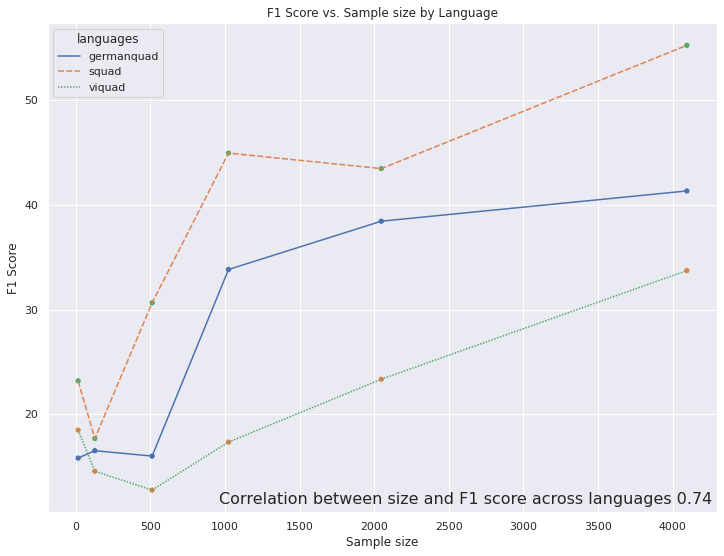

In [ ]:
plt.figure(figsize=(12,9))
sns.lineplot(data=results.pivot_table(columns='languages', index='sizes', values='results'))
sns.scatterplot(data=results, x='sizes', y='results', hue='languages', legend=False, units='results')
plt.title('F1 Score vs. Sample size by Language')
plt.xlabel('Sample size')
plt.ylabel('F1 Score')
plt.annotate(f'Correlation between size and F1 score across languages {results[["sizes", "results"]].corr()["results"][0].round(3)}', xy=(1, 0), xycoords='axes fraction', fontsize=16,
            xytext=(-5, 5), textcoords='offset points',
            ha='right', va='bottom')

In [ ]:
results.pivot_table(columns='languages', index='sizes', values='results')


languages,germanquad,squad,viquad
sizes,,,
16,15.810667,23.188080,18.486134
128,16.517944,17.682409,14.551264
512,15.999239,30.648581,12.753188
1024,33.834061,44.962151,17.341040
2048,38.449986,43.475296,23.345425
4096,41.340145,55.261436,33.732800


In [ ]:
languages_results = results[['sizes', 'languages', 'results']].pivot_table(index='sizes', columns='languages', values='results')

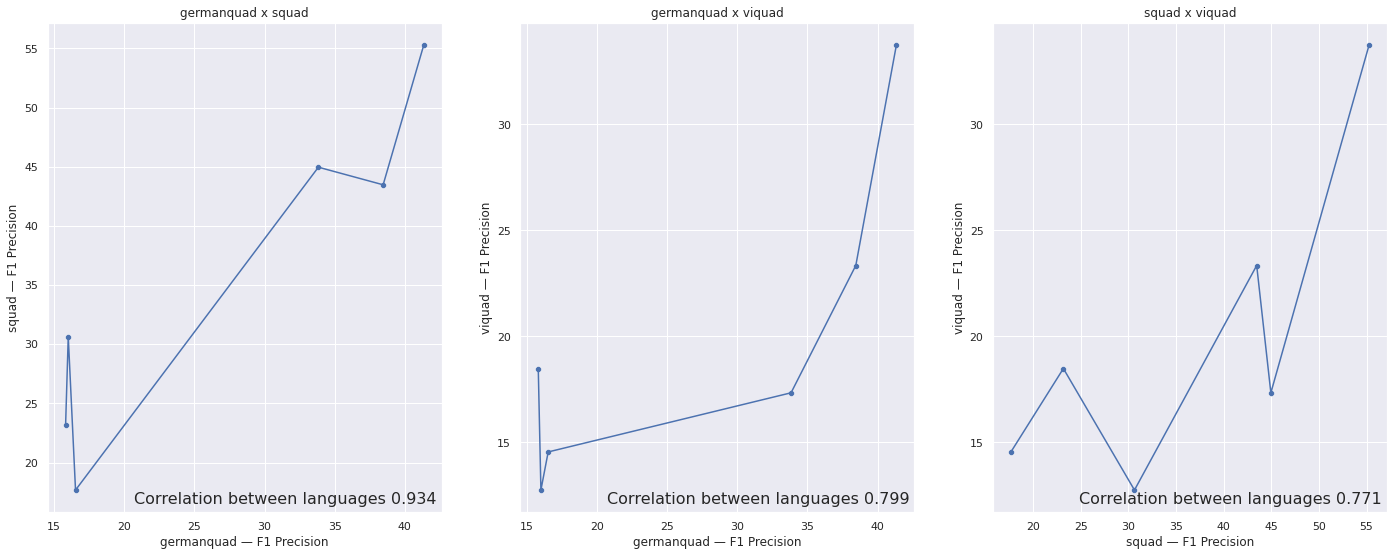

In [ ]:
pairs = [('germanquad', 'squad'), ('germanquad', 'viquad'), ('squad', 'viquad')]
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,9))
for i, ax in zip(pairs,[ax1, ax2, ax3]):
  x, y = i
  sns.lineplot(data=languages_results, x=x, y=y, ax=ax, )
  sns.scatterplot(data=languages_results, x=x, y=y, ax=ax)
  ax.set_xlabel(f'{x} — F1 Precision')
  ax.set_ylabel(f'{y} — F1 Precision')
  ax.set_title(f'{x} x {y}')
  ax.annotate(f'Correlation between languages {languages_results.corr()[x][y].round(3)}', xy=(1, 0), xycoords='axes fraction', fontsize=16,
            xytext=(-5, 5), textcoords='offset points',
            ha='right', va='bottom')

In [ ]:
mbert_viquad_faquad = pd.read_csv('/drive/MyDrive/projeto_final/output/run_18_mbert_viquad_faquad.csv')

Text(0, 0.5, 'F1 Score')

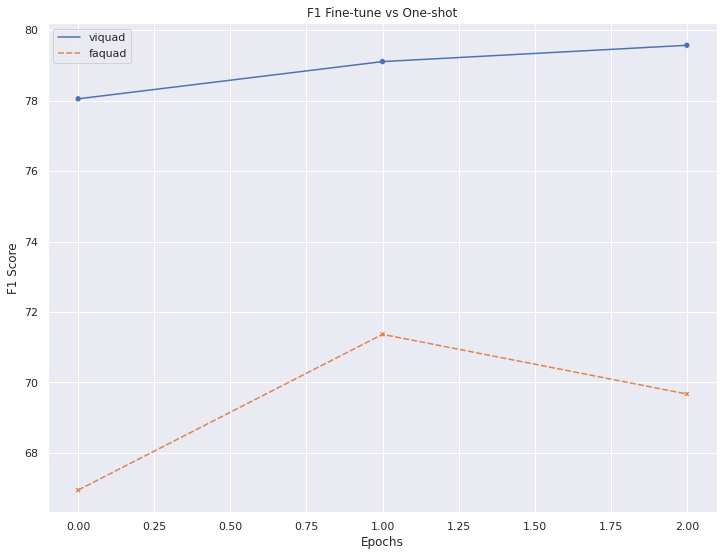

In [ ]:
plt.figure(figsize=(12,9))
sns.lineplot(data=mbert_viquad_faquad[['viquad', 'faquad']])
sns.scatterplot(data=mbert_viquad_faquad[['viquad', 'faquad']], legend=False)
plt.title('F1 Fine-tune vs One-shot')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')

In [ ]:
mbert_viquad_faquad.transpose()

,0,1,2
Unnamed: 0,0.000000,1.000000,2.000000
epoch,0.000000,1.000000,2.000000
viquad,78.053871,79.110046,79.573090
faquad,66.946129,71.366890,69.673386
